# Research on car sales ads
In this project, we will explore a dataset from Crankshaft List, a free vehicle advertising site.  Our goal is to examine how different features of a vehicle impact its price.

First, we will identify problems with the dataset, including missing data and incorrect data types.  After filling in the missing values and fixing the data types, we will draw histograms to identify anomalies and outliers.  After correcting the anomalies and filtering out the outliers, we will identify the most common vehicle types and determine how features of a vehicle affect its price.

## Open the data file and study the general information. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import warnings

warnings.filterwarnings('ignore')

try:
    df = pd.read_csv('vehicles_us.csv')
except:
    df = pd.read_csv('/datasets/vehicles_us.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         51525 non-null  int64  
 1   model_year    47906 non-null  float64
 2   model         51525 non-null  object 
 3   condition     51525 non-null  object 
 4   cylinders     46265 non-null  float64
 5   fuel          51525 non-null  object 
 6   odometer      43633 non-null  float64
 7   transmission  51525 non-null  object 
 8   type          51525 non-null  object 
 9   paint_color   42258 non-null  object 
 10  is_4wd        25572 non-null  float64
 11  date_posted   51525 non-null  object 
 12  days_listed   51525 non-null  int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 5.1+ MB


In [2]:
df.head()

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
0,9400,2011.0,bmw x5,good,6.0,gas,145000.0,automatic,SUV,NaN,1.0,2018-06-23,19
1,25500,NaN,ford f-150,good,6.0,gas,88705.0,automatic,pickup,white,1.0,2018-10-19,50
2,5500,2013.0,hyundai sonata,like new,4.0,gas,110000.0,automatic,sedan,red,NaN,2019-02-07,79
3,1500,2003.0,ford f-150,fair,8.0,gas,NaN,automatic,pickup,NaN,NaN,2019-03-22,9
4,14900,2017.0,chrysler 200,excellent,4.0,gas,80903.0,automatic,sedan,black,NaN,2019-04-02,28


In [3]:
df.tail()

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
51520,9249,2013.0,nissan maxima,like new,6.0,gas,88136.0,automatic,sedan,black,NaN,2018-10-03,37
51521,2700,2002.0,honda civic,salvage,4.0,gas,181500.0,automatic,sedan,white,NaN,2018-11-14,22
51522,3950,2009.0,hyundai sonata,excellent,4.0,gas,128000.0,automatic,sedan,blue,NaN,2018-11-15,32
51523,7455,2013.0,toyota corolla,good,4.0,gas,139573.0,automatic,sedan,black,NaN,2018-07-02,71
51524,6300,2014.0,nissan altima,good,4.0,gas,NaN,automatic,sedan,NaN,NaN,2018-06-05,10


### Conclusion
- There are 51,525 rows.
- Columns with missing values: <code>model_year</code>, <code>cylinders</code>, <code>odometer</code>, <code>paint_color</code>, <code>is_4wd</code>
- Data type changes
    - <code>model_year</code> &rarr; <code>int</code>
    - <code>condition</code>  &rarr; <code>int</code>
    - <code>cylinders</code> &rarr; <code>int</code>
    - <code>is_4wd</code> &rarr; <code>boolean</code>
    - <code>date_posted</code> &rarr; <code>datetime</code>

## Data preprocessing

### model_year & odometer
There are 3,619 entries with a missing <code>model year</code>.  The represents about 7% of total entries.  There are 7,892 entries with a missing <code>odometer</code> reading, representing about 15% of total entries.

The missing values probably resulted from the user failing to enter the the data when placing the ad.  The web form could be improved by refusing to accept ad submissions without these values.

How can we replace the missing values?  It makes sense that older cars will have higher mileage.  If so, then we can replace missing <code>model_year</code>s with the median <code>model_year</code> for the car's <code>odometer</code> reading.  Similarly, we can replace missing <code>odometer</code> readings with the median for the car's <code>model_year</code>.  The median was chosen instead instead of the mean because, as will be shown in a later section, there are outliers in the distributions of these parameters.

There are 549 entries that are missing _both_ <code>model_year</code> and <code>odometer</code>.  For these, we will replace the missing values with the overall averages.

First, let's check the degree of correlation between these variables.

In [4]:
df['model_year'].corr(df['odometer'])

-0.47394785819529395

As expected, the values are negatively correlated:  higher (newer) <code>model_year</code>s have lower <code>odometer</code> readings.  The degree of correlation could probably be described as "moderate."

First, we will fill in missing values for the rows missing both <code>model_year</code> and <code>odometer</code> with the overal averages.

In [5]:
len(df[(df['model_year'].isnull()) & (df['odometer'].isnull())])

549

In [6]:
df.loc[(df['model_year'].isnull()) & (df['odometer'].isnull()), 'model_year'] = df['model_year'].median(skipna=True)
df.loc[(df['model_year'].isnull()) & (df['odometer'].isnull()), 'odometer'] = df['odometer'].median(skipna=True)

In [7]:
len(df[(df['model_year'].isnull()) & (df['odometer'].isnull())])

0

With the "doubly missing" rows taken care of, we can proceed with filling in <code>odometer</code> readings based on the <code>model_year</code>, and vice versa.

In [8]:
df['odometer'].isnull().sum()

7892

In [9]:
df['model_year'].isnull().sum()

3070

In [10]:
# Fill in missing odometer readings based on the model year
model_year_groups = pd.qcut(df['model_year'], 10)
odo_lookup = df.groupby(model_year_groups)['odometer'].apply(lambda x: x.median())
df.loc[df['odometer'].isnull(), 'odometer'] = df[df['odometer'].isnull()].apply(lambda x: odo_lookup.loc[x['model_year']], axis=1)

# Fill in missing model years based on the odometer
odo_groups = pd.qcut(df['odometer'], 10)
model_year_lookup = df.groupby(odo_groups)['model_year'].apply(lambda x: x.median())
df.loc[df['model_year'].isnull(), 'model_year'] = df[df['model_year'].isnull()].apply(lambda x: model_year_lookup.loc[x['odometer']], axis=1)

In [11]:
df['odometer'].isnull().sum()

0

In [12]:
df['model_year'].isnull().sum()

0

There are no fractional <code>model_years</code>, so we will change the type of this column to <code>int</code>:

In [13]:
df['model_year'] = df['model_year'].astype('int')
df.head()

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
0,9400,2011,bmw x5,good,6.0,gas,145000.0,automatic,SUV,NaN,1.0,2018-06-23,19
1,25500,2013,ford f-150,good,6.0,gas,88705.0,automatic,pickup,white,1.0,2018-10-19,50
2,5500,2013,hyundai sonata,like new,4.0,gas,110000.0,automatic,sedan,red,NaN,2019-02-07,79
3,1500,2003,ford f-150,fair,8.0,gas,156440.0,automatic,pickup,NaN,NaN,2019-03-22,9
4,14900,2017,chrysler 200,excellent,4.0,gas,80903.0,automatic,sedan,black,NaN,2019-04-02,28


### type
There are no missing values for the <code>type</code> column, but there are redundancies.  In particular, <code>truck</code> and <code>pickup</code> refer to the same <code>model</code>s.  We will combine these types into a single <code>type</code>. Similarly, we will roll <code>offroad</code> into the <code>SUV</code> type.  There are redundancies in several other categories as well (e.g., <code>other</code>), but because the counts are small and there is no clear, single replacement type, we will leave them as-is.

In [14]:
df.loc[df['type'] == 'pickup', 'type'] = 'truck'
df.loc[df['type'] == 'offroad', 'type'] = 'SUV'
df['type'].value_counts()

truck          19341
SUV            12619
sedan          12154
coupe           2303
wagon           1541
mini-van        1161
hatchback       1047
van              633
convertible      446
other            256
bus               24
Name: type, dtype: int64

### cylinders
<code>cylinders</code> is missing for 5,260 entries, representing about 10% of the total.  Is there another variable in the data that can help us fill in missing <code>cylinder</code> values?  Larger vehicles, like trucks and SUVs, tend to have more cylinders; smaller vehicles have fewer.  We can check this by finding the most common number of cylinders by vehicle type.

In [15]:
df.groupby('type')['cylinders'].agg('median')

type
SUV             6.0
bus            10.0
convertible     8.0
coupe           6.0
hatchback       4.0
mini-van        6.0
other           6.0
sedan           4.0
truck           8.0
van             6.0
wagon           4.0
Name: cylinders, dtype: float64

This confirms our intuition regarding the relationship between vehicle <code>type</code> and number of <code>cylinder</code>s.  We will fill in missing <code>cylinder</code> values with the median number of cylinders for that vehicle <code>type</code>.

We will also convert to <code>int</code>, as there are no fractional cylinder values.

In [16]:
df['cylinders'] = df.groupby('type')['cylinders'].apply(lambda x: x.fillna(x.median()))
df['cylinders'] = df['cylinders'].astype('int')
df['cylinders'].value_counts(dropna=False)

8     17859
6     17391
4     15414
10      553
5       272
3        34
12        2
Name: cylinders, dtype: int64

### paint_color
There are 9,267 missing values for <code>paint_color</code>.  Most of these are probably while, black or silver &mdash; the most common colors &mdash; but because color isn't clearly tied to another feature of the vehicle, we don't have a logical way to "guess" the missing values.  Instead, we will set a default value of 'unavailable'.

In [17]:
df['paint_color'] = df['paint_color'].fillna('unavailable')
df['paint_color'].value_counts(dropna=False)

white          10029
unavailable     9267
black           7692
silver          6244
grey            5037
blue            4475
red             4421
green           1396
brown           1223
custom          1153
yellow           255
orange           231
purple           102
Name: paint_color, dtype: int64

### is_4wd
The column name implies a <code>boolean</code> value.  Instead, we have 1.0 representing <code>True</code> and <code>NaN</code> representing <code>False</code>.  We will change this to boolean.

In [18]:
df['is_4wd'] = df['is_4wd'].apply(lambda x: True if x == 1.0 else False)

### condition
We will replace the string values with a numeric scale.

In [19]:
def replace_condition(c):
    if c == 'new':
        return 5
    if c == 'like new':
        return 4
    if c == 'excellent':
        return 3
    if c == 'good':
        return 2
    if c == 'fair':
        return 1
    if c == 'salvage':
        return 0
    print('Error: ' + c)

df['condition'] = df['condition'].apply(replace_condition)
df.head()

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
0,9400,2011,bmw x5,2,6,gas,145000.0,automatic,SUV,unavailable,True,2018-06-23,19
1,25500,2013,ford f-150,2,6,gas,88705.0,automatic,truck,white,True,2018-10-19,50
2,5500,2013,hyundai sonata,4,4,gas,110000.0,automatic,sedan,red,False,2019-02-07,79
3,1500,2003,ford f-150,1,8,gas,156440.0,automatic,truck,unavailable,False,2019-03-22,9
4,14900,2017,chrysler 200,3,4,gas,80903.0,automatic,sedan,black,False,2019-04-02,28


### date_posted
We will convert this from <code>str</code> to <code>datetime</code>.

In [20]:
df['date_posted'] = pd.to_datetime(df['date_posted'], format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   price         51525 non-null  int64         
 1   model_year    51525 non-null  int64         
 2   model         51525 non-null  object        
 3   condition     51525 non-null  int64         
 4   cylinders     51525 non-null  int64         
 5   fuel          51525 non-null  object        
 6   odometer      51525 non-null  float64       
 7   transmission  51525 non-null  object        
 8   type          51525 non-null  object        
 9   paint_color   51525 non-null  object        
 10  is_4wd        51525 non-null  bool          
 11  date_posted   51525 non-null  datetime64[ns]
 12  days_listed   51525 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(1), int64(5), object(5)
memory usage: 4.8+ MB


### Conclusion
- Missing values have been replaced for <code>model_year</code>, <code>cylinders</code>, <code>odometer</code>, <code>paint_color</code>, <code>is_4wd</code>.  Where possible, defaults values based on other characteristics of the vehicle were used.
- We changed from <code>float</code> to <code>int</code> for the <code>model_year</code> and <code>cylidners</code>, since these columns have no fractional data.
- We changed <code>is_4wd</code> to <code>boolean</code>.
- We changed <code>date_posted</code> to <code>datetime</code>.

## Make calculations and add them to the table

### Day of the week, month, and year the ad was placed

In [21]:
df['weekday_posted'] = df['date_posted'].dt.weekday
df['month_posted'] = df['date_posted'].dt.month
df['year_posted'] = df['date_posted'].dt.year

### Age (in years) when the ad was placed
We add 1 to the <code>age</code>.  We are, in effect, rounding the <code>age</code> up rather than rounding it down.  This avoids division by zero when calculating <code>miles_per_year</code>.

In [22]:
df['age'] = df['year_posted'] - df['model_year'] + 1

### Average mileage per year

In [23]:
df['miles_per_year'] = df['odometer'] / df['age']
df['miles_per_year'] = df['miles_per_year'].round(0)

### Conclusion
In this section, we added several columns to the data:
- From <code>date_posted</code>, we derived the additional columns  <code>weekday_posted</code>, <code>month_posted</code>, and <code>year_posted</code>
- From <code>year_posted</code> and <code>model_year</code>, we derived <code>age</code>.
- From <code>odometer</code> and <code>age</code>, we derived <code>miles_per_year</code>.

## Exploratory data analysis

### Histograms for selected parameters

#### model_year

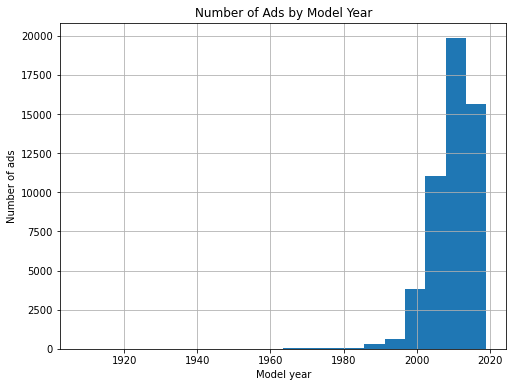

In [24]:
plt.figure(figsize=(8,6))
plt.hist(df['model_year'], bins=20)
plt.title('Number of Ads by Model Year')
plt.xlabel('Model year')
plt.ylabel('Number of ads')
plt.grid()
plt.show()

Most of the ads are for <code>model_year</code>s after 2000, but there are outliers going as far back as 1908.

#### odometer

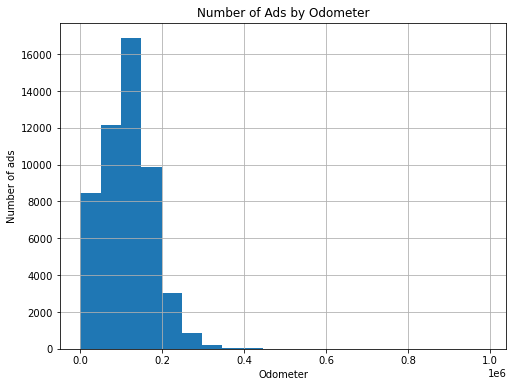

In [25]:
plt.figure(figsize=(8,6))
plt.hist(df['odometer'], bins=20)
plt.title('Number of Ads by Odometer')
plt.xlabel('Odometer')
plt.ylabel('Number of ads')
plt.grid()
plt.show()

The histogram shows that most vehicles have less than 200,000 miles, but there are high outliers with almost a million miles.  (The maximum value is 990,000 miles.)  There is also an unexpected peak near zero miles.

Let's "zoom in" on the vehicles with low odometer readings.

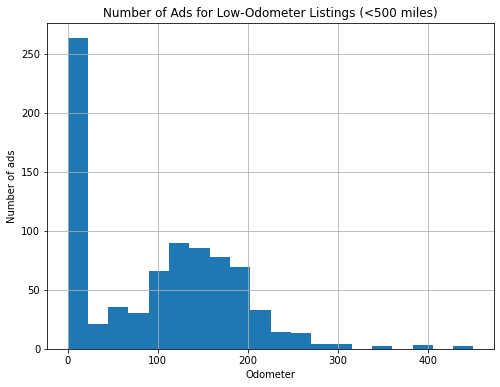

In [26]:
plt.figure(figsize=(8,6))
plt.hist(df.query('odometer < 500')['odometer'], bins=20)
plt.title('Number of Ads for Low-Odometer Listings (<500 miles)')
plt.xlabel('Odometer')
plt.ylabel('Number of ads')
plt.grid()
plt.show()

This histogram, which focuses on low <code>odometer</code> readings, shows not just the peak at zero but also a surprisingly large number of vehicles with less than 300 miles.  Let's inspect these in greater detail.

In [27]:
df.query('odometer < 400').head()

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed,weekday_posted,month_posted,year_posted,age,miles_per_year
73,1900,1994,jeep grand cherokee laredo,2,6,gas,207.0,automatic,SUV,grey,True,2018-07-27,9,4,7,2018,25,8.0
222,2750,2006,honda civic lx,2,4,gas,200.0,manual,sedan,black,False,2018-07-06,41,4,7,2018,13,15.0
352,7997,2009,gmc yukon,3,8,gas,0.0,automatic,SUV,white,True,2019-03-16,88,5,3,2019,11,0.0
501,6300,2003,toyota rav4,3,4,gas,107.0,automatic,SUV,red,True,2018-09-16,24,6,9,2018,16,7.0
510,3900,2008,ford escape,2,4,gas,137.0,automatic,SUV,unavailable,False,2018-08-02,59,3,8,2018,11,12.0


Inspection of these listings reveals that these vehicles are fairly old, despite their low odometer readings.  Many of these would be more reasonable-looking if multiplied by 1,000.

#### cylinders

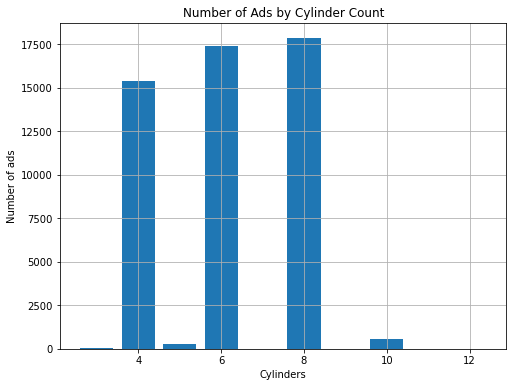

In [28]:
cylinders = df['cylinders'].value_counts().index
counts = df['cylinders'].value_counts().values
plt.figure(figsize=(8,6))
plt.bar(cylinders, height=counts)
plt.title('Number of Ads by Cylinder Count')
plt.xlabel('Cylinders')
plt.ylabel('Number of ads')
plt.grid()
plt.show()

The vast majority of vehicles have 4, 6, or 8 cylinders.

#### condition

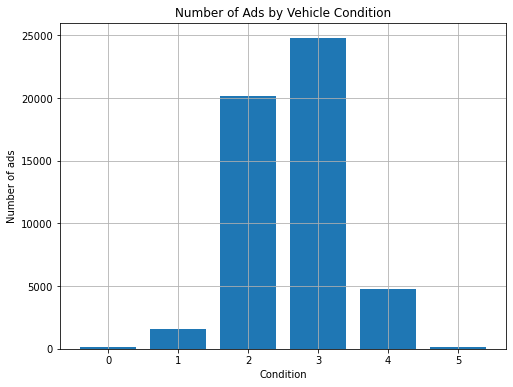

In [29]:
condition = df['condition'].value_counts().index
counts = df['condition'].value_counts().values
plt.figure(figsize=(8,6))
plt.bar(condition, height=counts)
plt.title('Number of Ads by Vehicle Condition')
plt.xlabel('Condition')
plt.ylabel('Number of ads')
plt.grid()
plt.show()

- Most vehicles have a condition rated as 2 ("good") or 3 ("excellent").
- A small number of vehicles are described as 1 ("fair") or 4 ("like new").
- Almost no vehicles are rated as 0 ("salvage") or 5 ("new").

#### days_listed

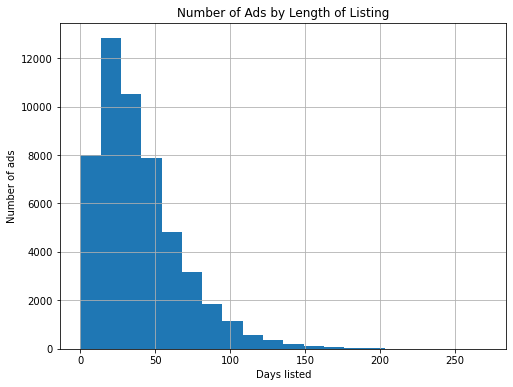

In [30]:
plt.figure(figsize=(8,6))
plt.hist(df['days_listed'], bins=20)
plt.title('Number of Ads by Length of Listing')
plt.xlabel('Days listed')
plt.ylabel('Number of ads')
plt.grid()
plt.show()

- Most ads are left up for about 30 days.
- The distribution is skewed to the right by high outliers, with some ads left up for more than 100 days.
- There is no huge peak at 0, as we saw above with <code>odometer</code>.

#### price

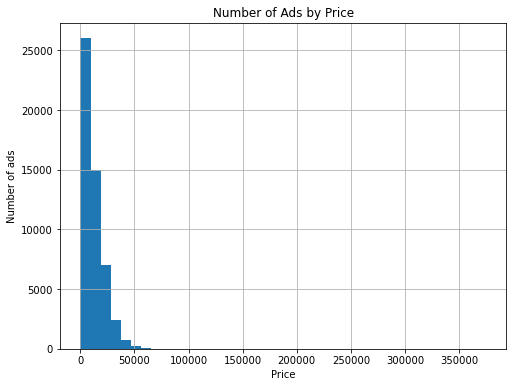

Median price: $9000
Max price: $375000


In [31]:
plt.figure(figsize=(8,6))
plt.hist(df['price'], bins=40)
plt.title('Number of Ads by Price')
plt.xlabel('Price')
plt.ylabel('Number of ads')
plt.grid()
plt.show()
print('Median price: ${:.0f}'.format(df['price'].median()))
print('Max price: ${}'.format(df['price'].max()))

- The median price is \\$9,000.
- There are some high outliers listed for as much as \\$375,000.
- There appears to be a peak near zero.

Let's zoom in on low-priced vehicles to examine the peak near zero.

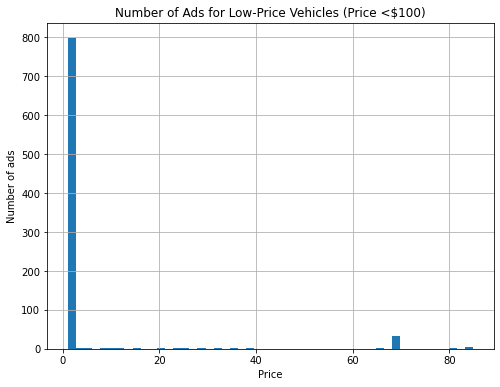

In [32]:
plt.figure(figsize=(8,6))
plt.hist(df.query('price < 100')['price'], bins=50)
plt.title('Number of Ads for Low-Price Vehicles (Price <$100)')
plt.xlabel('Price')
plt.ylabel('Number of ads')
plt.grid()
plt.show()

The histogram focusing on low-price vehicles shows a large peak just above \\$0.  Manual inspection of the data reveals that the anomalous price is \\$1.  In some jurisdictions, you can't give away a car for free; instead, you must sell the vehicle for \\$1 to be able to transfer the title to the buyer. These vehicles are not in 'salvage' condition, as one might expect.

### Identification of outliers

#### model_year
Defining a low outlier as <code>Q1 - 1.5 x IQR</code> and a high outlier as <code>Q3 + 1.5 x IQR</code>, we will discard <code>model_year</code>s before 1994 as low outliers.  (There are no high outliers for <code>model_year</code>.)

In [33]:
def get_outliers(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outlier_lower_bound = Q1 - 1.5 * IQR
    outlier_upper_bound = Q3 + 1.5 * IQR
    return outlier_lower_bound, outlier_upper_bound

outlier_lower_bound, outlier_upper_bound = get_outliers('model_year')
print('Discard models older than {:.0f} and newer than {:.0f}.'.format(outlier_lower_bound, outlier_upper_bound))
min_model_year = outlier_lower_bound

Discard models older than 1994 and newer than 2026.


#### odometer
In an earlier section, our histogram showed a large number of vehicles with suspicious <code>odometer</code> readings <300 miles.  Many had readings of 0 even though they were older vehicles, suggesting a missing value.  Others appeared to have readings that were too small by a factor of 1,000.  We will replace these anomalous values with the median based on the vehicle's <code>model_year</code>.  Then, based on the outlier formula, we will dischard odometer readings >270,206 miles.  (There are no low outliers.)

In [34]:
odo_lookup = df.groupby('model_year')['odometer'].apply(lambda x: x.median())
df.loc[df['odometer'] < 300, 'odometer'] = df[df['odometer'] < 300].apply(lambda x: odo_lookup.loc[x['model_year']], axis=1)

outlier_lower_bound, outlier_upper_bound = get_outliers('odometer')
print('Discard vehicles with less than {:.0f} miles and and more than {:.0f}.'.format(outlier_lower_bound, outlier_upper_bound))
max_odometer = outlier_upper_bound

Discard vehicles with less than -39678 miles and and more than 270206.


#### cylinders
Earlier, we found that the vast majority of vehicles have 4, 6, or 8 <code>cylinders</code>.  Manual inspection of the data for other cylinder counts (3, 5, 10, and 12) reveals a large proportion of "bad data," such as
- a ford f-150 with 3 cylinders
- a toyota camry with 10 cylidners

For these reasons, we will limit further analysis to vehicles with 4, 6, or 8 cylinders.

#### condition
We found that there were almost no vehicles listed as condition 0 (salvage) or 5 (new).  We will focus further analysis on conditions 1-4.

#### days_listed
We will discard outliers with days_listed > 104.

In [35]:
outlier_lower_bound, outlier_upper_bound = get_outliers('days_listed')
print('Discard models with fewer than {:.0f} and more {:.0f} days_listed.'.format(outlier_lower_bound, outlier_upper_bound))
max_days_listed = outlier_upper_bound

Discard models with fewer than -32 and more 104 days_listed.


#### price
We found that <code>price</code> had a large peak at \\$1.  We will assign these the mean value based on <code>type</code>, <code>model_year</code>, and <code>condition</code>.  Using the outlier formula, we will filter out high prices >$34,388.

In [36]:
price_lookup = df.groupby(['type', 'model_year', 'condition'])['price'].apply(lambda x: x.mean())
df.loc[df['price'] == 1, 'price'] = df[df['price'] == 1].apply(lambda x: price_lookup.loc[(x['type'], x['model_year'], x['condition'])], axis=1)

# The filter above missed 2 entries. Applying a less selective filter to catch them:
price_lookup = df.groupby(['model_year'])['price'].apply(lambda x: x.mean())
df.loc[df['price'] == 1, 'price'] = df[df['price'] == 1].apply(lambda x: price_lookup.loc[(x['model_year'])], axis=1)

outlier_lower_bound, outlier_upper_bound = get_outliers('price')
print('Discard models with price less than ${:.0f} and more than ${:.0f}.'.format(outlier_lower_bound, outlier_upper_bound))

max_price = outlier_upper_bound

Discard models with price less than $-11992 and more than $34388.


### Histograms with outliers filtered out

In [37]:
df_filtered = df.query('model_year >= @min_model_year and \
                        odometer <= @max_odometer and \
                        (cylinders == 4 or \
                        cylinders == 6 or \
                        cylinders == 8) and \
                        condition >= 1 and \
                        condition <= 4 and \
                        days_listed <= @max_days_listed and \
                        price <= @max_price')

#### model_year

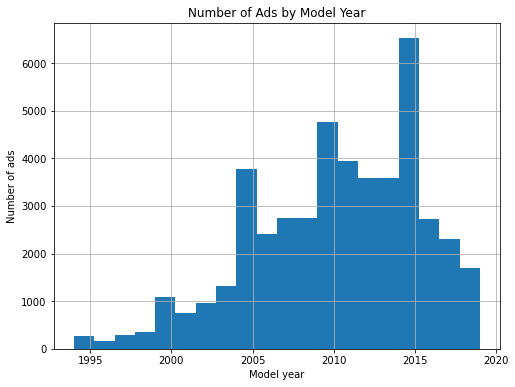

Mean model year: 2010.0
Median model year: 2011.0


In [38]:
plt.figure(figsize=(8,6))
plt.hist(df_filtered['model_year'], bins=20)
plt.title('Number of Ads by Model Year')
plt.xlabel('Model year')
plt.ylabel('Number of ads')
plt.grid()
plt.show()
print("Mean model year: {}".format(round(df_filtered['model_year'].mean(), 0)))
print("Median model year: {}".format(df_filtered['model_year'].median()))

This histogram, with outlier model years before 1994 removed, is still skewed slightly to the left by lower model years.

#### odometer

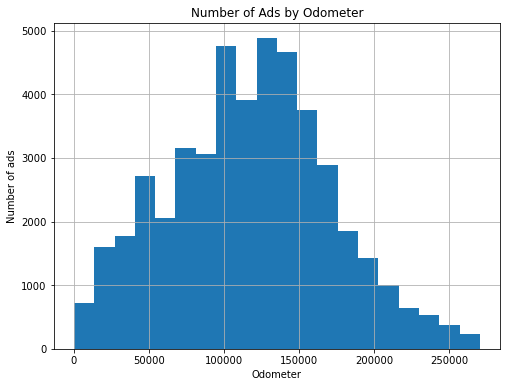

Mean odometer: 117100.0
Median odometer: 119000.0


In [39]:
plt.figure(figsize=(8,6))
plt.hist(df_filtered['odometer'], bins=20)
plt.title('Number of Ads by Odometer')
plt.xlabel('Odometer')
plt.ylabel('Number of ads')
plt.grid()
plt.show()
print("Mean odometer: {}".format(round(df_filtered['odometer'].mean(), 0)))
print("Median odometer: {}".format(df_filtered['odometer'].median()))

In the above histogram, we have eliminated the anomalous low odometer readings (<300 miles) and have trimmed away the high outliers seen previously.

#### cylinders

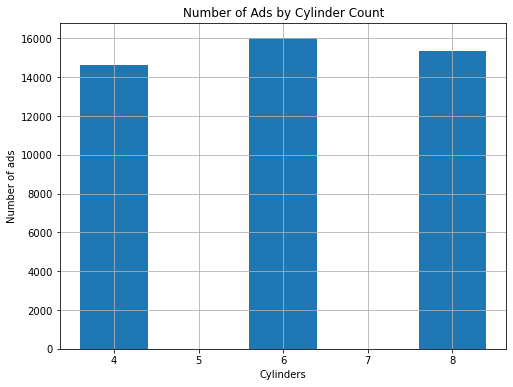

In [40]:
cylinders = df_filtered['cylinders'].value_counts().index
counts = df_filtered['cylinders'].value_counts().values
plt.figure(figsize=(8,6))
plt.bar(cylinders, height=counts)
plt.title('Number of Ads by Cylinder Count')
plt.xlabel('Cylinders')
plt.ylabel('Number of ads')
plt.grid()
plt.show()

Earlier we found that most vehicles have 4, 6, or 8 cylinders.  We also manually inspected the data and found that some of the listings with other values were erroneous.  Going forward, we will focus on vehicles with 4, 6, or 8 cylinders.

#### condition

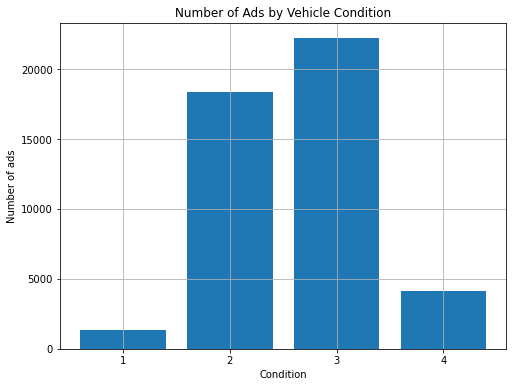

In [41]:
condition = df_filtered['condition'].value_counts().index
counts = df_filtered['condition'].value_counts().values
plt.figure(figsize=(8,6))
plt.bar(condition, height=counts)
plt.xticks(range(1,5))
plt.title('Number of Ads by Vehicle Condition')
plt.xlabel('Condition')
plt.ylabel('Number of ads')
plt.grid()
plt.show()

Further analysis will focus on the most common conditions: fair (1), good (2), excellent (3), and like new (4). We have filtered out salvage (0) and new (5).

#### days_listed

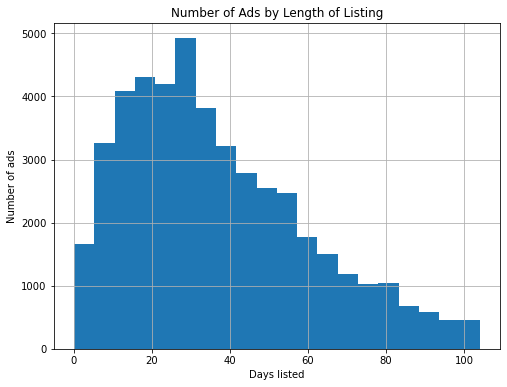

Mean days_listed: 37.0
Median days_listed: 32.0


In [42]:
plt.figure(figsize=(8,6))
plt.hist(df_filtered['days_listed'], bins=20)
plt.title('Number of Ads by Length of Listing')
plt.xlabel('Days listed')
plt.ylabel('Number of ads')
plt.grid()
plt.show()
print("Mean days_listed: {}".format(round(df_filtered['days_listed'].mean(), 0)))
print("Median days_listed: {}".format(df_filtered['days_listed'].median()))

For this histogram, we have filtered high outliers for <code>days_listed</code>.  The distribution is still somewhat skewed to the right by long listing times.

#### price

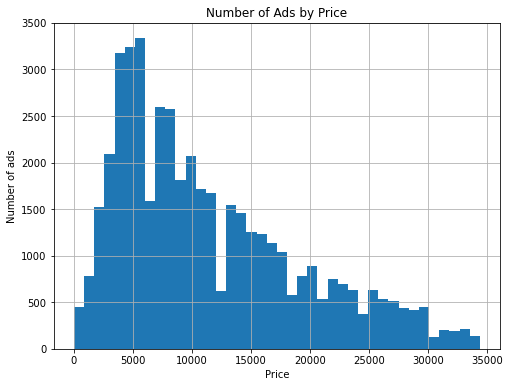

Mean price: $11468.0
Median price: $9200.0


In [43]:
plt.figure(figsize=(8,6))
plt.hist(df_filtered['price'], bins=40)
plt.title('Number of Ads by Price')
plt.xlabel('Price')
plt.ylabel('Number of ads')
plt.grid()
plt.show()
print("Mean price: ${}".format(round(df_filtered['price'].mean(), 0)))
print("Median price: ${}".format(df_filtered['price'].median()))

For this histogram, we have elimited vehicles with anomalous $1 prices and have trimmed high outliers.  The distribution is skewed to the right by higher-priced ads.

### Life cycle of an ad
In the previous section, we found that the mean <code>days_listed</code> for an ad is about 37 days.  Even with high outliers filtered out, this is greater than the median, which is 32 days.

Is there a pattern in the data to explain why some ads are taken down in a day or two, while others are left up for more than 100 days?  The table below, which shows vehicle features broken down by <code>days_listed</code>, is an attempt to answer this question.

In [44]:
def mode(x):
    return scipy.stats.mode(x)[0]

#df_filtered = df_filtered.query('model == "ford f-150"')

df_filtered.groupby( pd.qcut(df_filtered['days_listed'], 5, 
                             ['low', 'below average', 'average', 'above average', 'high'])).agg(
                                {'price':'mean',
                                 'model_year':'median',
                                 'model':lambda x: pd.Series.mode(x),
                                 'condition':'mean',
                                 'cylinders':lambda x: pd.Series.mode(x),
                                 'fuel':lambda x: pd.Series.mode(x),
                                 'odometer':'mean',
                                 'transmission':lambda x: pd.Series.mode(x),
                                 'type':lambda x: pd.Series.mode(x),
                                 'paint_color':lambda x: pd.Series.mode(x),
                                 'is_4wd':'mean',
                                 'weekday_posted':lambda x: pd.Series.mode(x),
                                 'month_posted':lambda x: pd.Series.mode(x),
                                 'year_posted':lambda x: pd.Series.mode(x),
                                 'age':'mean',
                                 'miles_per_year':'mean'})

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,weekday_posted,month_posted,year_posted,age,miles_per_year
days_listed,,,,,,,,,,,,,,,,
low,11468.734148,2011.0,ford f-150,2.633191,6,gas,116459.976567,automatic,truck,white,0.477886,0,10,2018,9.212112,14405.728748
below average,11442.235031,2011.0,ford f-150,2.634659,6,gas,117680.267442,automatic,truck,white,0.483014,1,7,2018,9.352481,14436.400493
average,11508.429943,2011.0,ford f-150,2.635070,6,gas,116532.102075,automatic,truck,white,0.482234,4,"[9, 10]",2018,9.167844,14542.189583
above average,11423.883920,2011.0,ford f-150,2.623853,6,gas,117894.716874,automatic,truck,white,0.487400,3,5,2018,9.332598,14299.296133
high,11496.477969,2011.0,ford f-150,2.638797,6,gas,117009.708745,automatic,truck,white,0.486724,3,12,2018,9.244898,14441.179724


This table shows that the features of ads in the bottom 20% for <code>days_listed</code> (which corresponds to <code>days_listed</code> <16) are similar to the features of ads in the top 20% (<code>days_listed</code> > 56).

Does this patter (or lack of a pattern) hold up for even more extreme values?  The following two tables show the vehicles with the very lowest and the very highest listing times.

In [45]:
df_filtered.sort_values(by='days_listed').head()

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed,weekday_posted,month_posted,year_posted,age,miles_per_year
1247,14995.0,2008,chevrolet silverado 1500,3,8,gas,93300.0,automatic,truck,grey,True,2018-05-15,0,1,5,2018,11,8482.0
12869,21997.0,2014,honda pilot,3,6,gas,37093.0,automatic,SUV,silver,True,2019-03-04,0,0,3,2019,6,6182.0
1983,14000.0,1999,ford f250,3,8,diesel,137500.0,automatic,truck,red,True,2018-09-27,0,3,9,2018,20,6875.0
16138,3650.0,2013,kia soul,2,4,gas,95367.0,manual,hatchback,grey,False,2019-01-27,0,6,1,2019,7,13624.0
9607,4999.0,2012,nissan sentra,3,4,gas,125000.0,automatic,sedan,silver,False,2019-03-26,0,1,3,2019,8,15625.0


In [46]:
df_filtered.sort_values(by='days_listed').tail()

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed,weekday_posted,month_posted,year_posted,age,miles_per_year
33720,16900.0,2014,ford f150,3,8,gas,100750.0,automatic,truck,unavailable,True,2019-04-17,104,2,4,2019,6,16792.0
29383,12900.0,2006,chevrolet silverado 2500hd,3,8,gas,185000.0,automatic,truck,unavailable,True,2019-03-30,104,5,3,2019,14,13214.0
29476,7995.0,2012,chevrolet cruze,3,4,gas,74000.0,automatic,sedan,blue,False,2018-06-18,104,0,6,2018,7,10571.0
38832,25500.0,2010,ram 2500,4,6,diesel,138000.0,automatic,truck,custom,True,2019-03-24,104,6,3,2019,10,13800.0
36178,3999.0,2002,ram 1500,3,8,gas,170000.0,automatic,truck,blue,False,2018-12-20,104,3,12,2018,17,10000.0


A clear pattern also fails to emerge when looking at the very top and very bottom of the data, sorted by <code>days_listed</code>.  (Although not shown, a pattern also does not emerge when looking at a single model.)

### Relationship between vehicle type and number of ads
Which vehicle types appear most frequently among ad listings?

In [47]:
total_rows = len(df_filtered)
proportion_by_type = df_filtered['type'].value_counts()/total_rows
most_popular_types = proportion_by_type[proportion_by_type > .04].index
df_filtered['type_tmp'] = df_filtered['type'].where(df_filtered['type'].isin(most_popular_types), 'other')

type_table = df_filtered.groupby('type_tmp')['price'].agg(['count', 
                                                           lambda x: x.count()/total_rows,
                                                           lambda x: x.mean()]).sort_values(by='count', ascending=False)

type_table.columns = ['count', 'percent', 'average price']
type_table.index.names = ['type']
type_table

,count,percent,average price
type,,,
truck,16537,0.359688,15434.781243
SUV,11586,0.252001,10801.891305
sedan,11336,0.246563,7085.465354
other,4617,0.100422,8676.502696
coupe,1900,0.041326,13941.944646


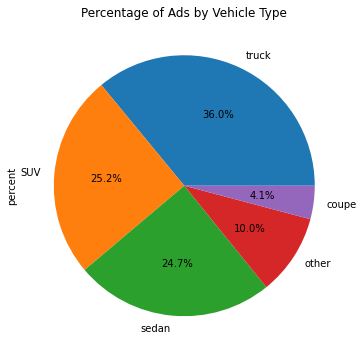

In [48]:
title = 'Percentage of Ads by Vehicle Type'
plt = type_table.plot(y='percent', kind='pie', legend=False, autopct='%1.1f%%', figsize=(12,6), title=title)

The pie chart shows that trucks, SUV's, and sedans account for 85% of ads placed.

### Factors impacting price
In this section, we focus on the top 2 types (trucks and SUVs) and examine factors that may affect the price.

#### age
Not surprisingly, there is a strong, negative correlation between price and age, for both SUVs and trucks.

The correlation coefficient was -0.66 for SUVs and -0.73 for trucks.  The hexbin plots show what appears to be a fairly linear pattern, with a negative slope.

##### SUV

SUV price-age correlation: -0.66.


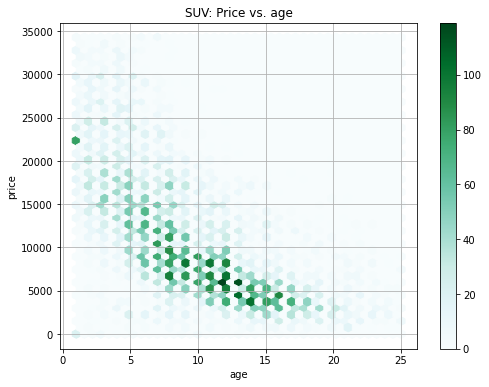

In [49]:
df_suv = df_filtered.query('type == "SUV"')
df_truck = df_filtered.query('type == "truck"')
gridsize = 40
figsize = (8,6)
print('SUV price-age correlation: {:.2f}.'.format(df_suv['price'].corr(df_suv['age'])))
df_suv.plot(x='age', y='price', kind='hexbin', gridsize=gridsize, figsize=figsize, grid=True, sharex=False, title='SUV: Price vs. age');

In addition to reflecting the negative correlation between price and age, the shape of the data hints at steep depreciation for newer vehicles, and a flattening of the depreciation curve for vehicles more than 15 years old.

##### truck

Truck price-age correlation: -0.73.


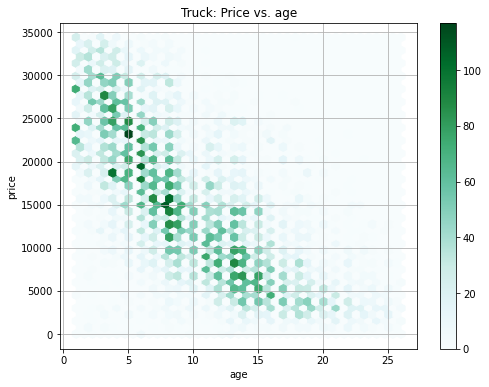

In [50]:
print('Truck price-age correlation: {:.2f}.'.format(df_truck['price'].corr(df_truck['age'])))
df_truck.plot(x='age', y='price', kind='hexbin', gridsize=gridsize, figsize=figsize, grid=True, sharex=False, title='Truck: Price vs. age');

As with SUVs, the hexbin plot for trucks clearly shows the negative correlation bewteen price and age.

#### Mileage
The relationship between price and mileage also showed a negative correlation.  The correlation coefficient for SUVs was -0.65, and for trucks was -0.62.

##### SUV

SUV price-mileage correlation: -0.65.


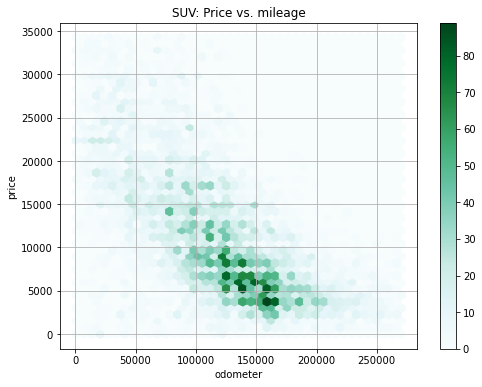

In [51]:
print('SUV price-mileage correlation: {:.2f}.'.format(df_suv['price'].corr(df_suv['odometer'])))
df_suv.plot(x='odometer', y='price', kind='hexbin', gridsize=gridsize, figsize=figsize, grid=True, sharex=False, title='SUV: Price vs. mileage');

##### truck

Truck price-mileage correlation: -0.62.


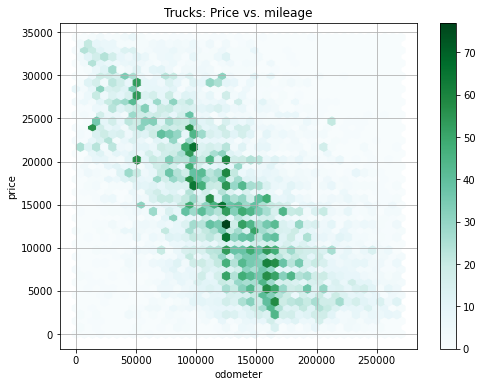

In [52]:
print('Truck price-mileage correlation: {:.2f}.'.format(df_truck['price'].corr(df_truck['odometer'])))
df_truck.plot(x='odometer', y='price', kind='hexbin', gridsize=gridsize, figsize=figsize, grid=True, sharex=False, title='Trucks: Price vs. mileage');

#### Condition

##### SUV

SUV price-condition correlation: 0.29.


Text(0, 0.5, 'Price')

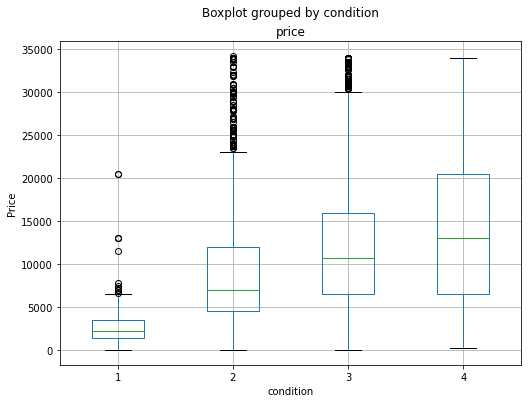

In [53]:
print('SUV price-condition correlation: {:.2f}.'.format(df_suv['price'].corr(df_suv['condition'])))
ax = df_suv.boxplot(column='price', by='condition', figsize=figsize)
ax.set_ylabel('Price')

The box plots show that as the condition increases, so does the price.  SUVs in excellent condition had a median price of about \\$13,500, while those in fair condition listed for about \\$2,500, a difference of \\$11,000.

The range of typical prices for each condition, represented by the interquartile range, increases along with the condition and price.  There are high outliers, particularly for vehicles rated good (2) and excellent (3).  There are no high outliers for like-new vehicles (4) because these outliers were filtered.

##### truck

Truck price-condition correlation: 0.30.


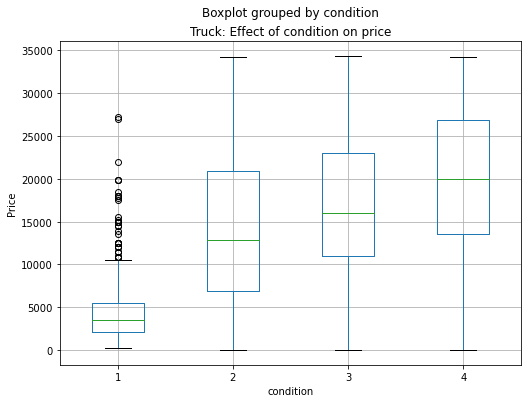

In [54]:
print('Truck price-condition correlation: {:.2f}.'.format(df_truck['price'].corr(df_truck['condition'])))
ax = df_truck.boxplot(column='price', by='condition', figsize=figsize)
ax.set_ylabel('Price')
ax.set_title('Truck: Effect of condition on price');

The boxplots relating price to condition for trucks also follows an intuitive trend.  Compared with SUVs, the relationship for trucks is even more pronounced.  Trucks in excellent condition had a median price of about \\$20,000, while those in fair condition listed for about \\$3,000, a difference of \\$17,000.  There were high outlier prices for trucks listed in fair condition.

#### Transmission

##### SUV

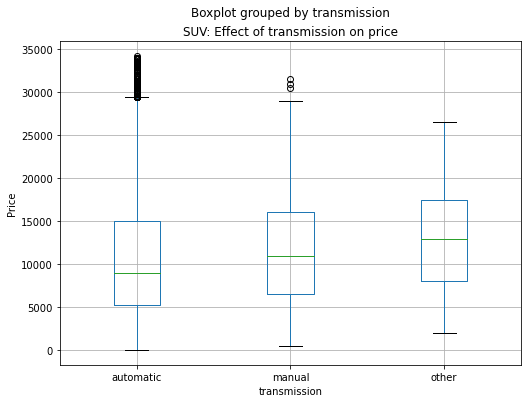

In [55]:
ax = df_suv.boxplot(column='price', by='transmission', figsize=figsize)
ax.set_ylabel('Price')
ax.set_title('SUV: Effect of transmission on price');

For SUVs, there is almost no relationship between the type of transmission type and price.  The median price for manual transmission is slightly higher than for automatics, but the IQRs largely overlap.

##### truck

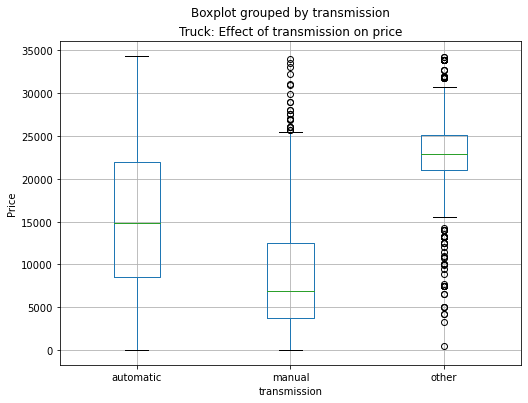

In [56]:
ax = df_truck.boxplot(column='price', by='transmission', figsize=figsize)
ax.set_ylabel('Price')
ax.set_title('Truck: Effect of transmission on price');

For trucks, manual transmission was associated with a lower price, but there are some high outliers. Let's examine these outliers.

In [57]:
df_truck.query('transmission == "manual" and price > 25000').head(10)

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed,weekday_posted,month_posted,year_posted,age,miles_per_year,type_tmp
5189,30995.0,2017,toyota tacoma,3,6,gas,30300.0,manual,truck,custom,True,2019-02-14,29,3,2,2019,3,10100.0,truck
7823,34000.0,2014,ram 2500,3,6,diesel,90000.0,manual,truck,white,False,2019-04-07,47,6,4,2019,6,15000.0,truck
8009,27500.0,2015,chevrolet silverado,4,8,gas,56000.0,manual,truck,white,True,2018-05-21,10,0,5,2018,4,14000.0,truck
13630,28950.0,2014,ram 2500,4,6,diesel,159875.0,manual,truck,white,True,2019-03-09,9,5,3,2019,6,26646.0,truck
14930,28900.0,2017,toyota tacoma,3,6,gas,47570.0,manual,truck,grey,True,2019-02-14,54,3,2,2019,3,15857.0,truck
15529,27000.0,2004,ram 2500,4,6,diesel,38400.0,manual,truck,unavailable,False,2018-07-31,38,1,7,2018,15,2560.0,truck
19639,31000.0,2017,chevrolet silverado 1500,3,8,gas,42400.0,manual,truck,white,True,2018-12-13,34,3,12,2018,2,21200.0,truck
20149,25500.0,2008,ram 2500,2,6,diesel,200000.0,manual,truck,blue,True,2018-12-29,27,5,12,2018,11,18182.0,truck
28577,29900.0,2014,ram 2500,3,6,diesel,95846.0,manual,truck,black,True,2018-11-27,44,1,11,2018,5,19169.0,truck
29751,25500.0,2007,ram 3500,3,6,diesel,91000.0,manual,truck,white,True,2019-01-07,11,0,1,2019,13,7000.0,truck


The list of relatively expensive trucks with manual transmission is dominated by Toyota Tacomas and Dodge Rams with diesel engines.

#### Color

In [58]:
proportion_by_color = df_filtered['paint_color'].value_counts()/len(df_filtered)
most_popular_colors = proportion_by_color[proportion_by_color > 0.09].index
df_filtered['color_tmp'] = df_filtered['paint_color'].where(df_filtered['paint_color'].isin(most_popular_colors), 'other')

color_table = df_filtered.groupby('color_tmp')['price'].agg(['count', 
                                                           lambda x: x.count()/total_rows,
                                                           lambda x: x.mean()])#.sort_values(by='price', ascending=False)
color_table.columns = ['count', 'percent', 'average price']
color_table = color_table.sort_values('average price', ascending=False)
color_table.index.names = ['paint_color']
color_table

,count,percent,average price
paint_color,,,
white,8720,0.189664,13019.161627
black,6849,0.148969,12929.698605
unavailable,8295,0.180420,11584.268196
grey,4563,0.099247,10663.519061
silver,5764,0.125370,10307.200063
other,11785,0.256329,10269.257076


White is the most popular color and is also associated with the highest average price.  Black comes in second place.

##### SUV

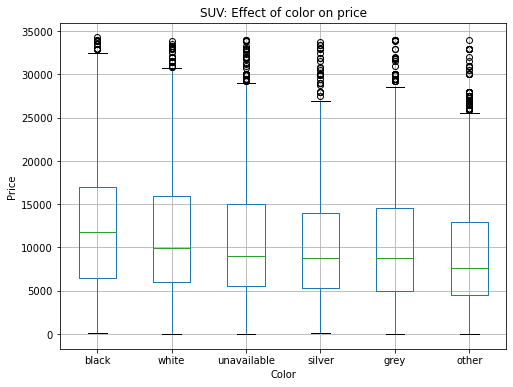

In [59]:
# This is to pick up the color_tmp column defined above
df_suv = df_filtered.query('type == "SUV"')
df_truck = df_filtered.query('type == "truck"')

def boxplot_sorted_df(df, by, column):
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    meds = df2.median().sort_values(ascending=False)
    return df2[meds.index]

ax = boxplot_sorted_df(df_suv, 'color_tmp', 'price').boxplot(figsize=figsize)
ax.set_ylabel('Price')
ax.set_xlabel('Color')
ax.set_title('SUV: Effect of color on price');

Although white is the most popular color overall, black is the most popular color for SUVs, and black also has the highest median price.  However, the IQRs for all colors overalap to a large degree.  This suggests that color does not have a strong influence on price.

##### truck

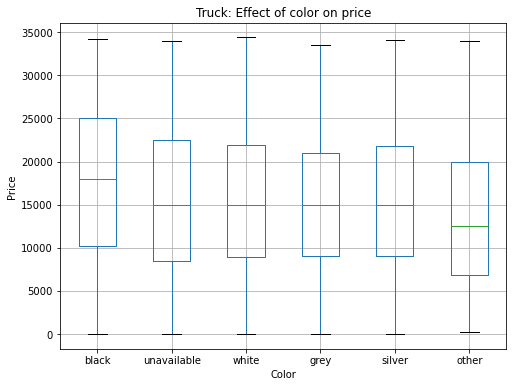

In [60]:
ax = boxplot_sorted_df(df_truck, 'color_tmp', 'price').boxplot(figsize=figsize)
ax.set_ylabel('Price')
ax.set_xlabel('Color')
ax.set_title('Truck: Effect of color on price');

The boxplots showing the relationship between color and price for trucks follows a pattern similar to that seen for SUVs.  Again, black is the most popular color and has the highest median price.  The median price for other popular colors (white, silver, and grey) were about the same as each other, and the IQRs for all colors mostly overlap, suggesting a weak relationship between color and price.

### Conclusion (EDA)
By drawing histograms for various features, we identified outliers and other anomalies in the data (e.g., odometer readings of 0, prices of $1).  In some cases, we limited the range of the histogram or manually inspected a subset of the data to identify anomalous values.

We filtered out the outliers and anomalies, and using the filtered data, we redrew the histograms.  We also used the filtered data to answer some questions about the data.  We found the average time an ad stays up, but we did not find a typical profile for ads that were taken down quickly, vs. those that were left up for a long time.

We identified the most popular vehicle types among ad listings (truck and SUV) and looked at factors that influence the price.  As expected, we found negative correlations between price and features such as mileage and age, and we found a positive correlation betwen price and condition.  We found that the price of vehicles with the most popular colors (black and white) was somewhat higher than for other colors.

## Overall conclusion
In this project, we explored how various features in vehicle ads influence the price of the vehicle.

Our initial look at the data revealed missing values and incorrect data types.  Where possible, we filled in missing values based on other features in the listings, and we converted data types to <code>int</code>, <code>boolean</code>, and <code>datetime</code> as appropriate.  We combined redundant vehicle types, such as "truck" and "pickup."  The web form used for ad submission should be improved to reduce missing data and to ensure data consistency.

Next, we proceeded with exploratory data analysis.  We drew histograms to explore the distributions of several features and to identify outliers.  We filtered out the outliers and redrew the histograms.  We investigated the life cycle of an ad.  We found that ads are left up for a little more than a month, on average.  We searched for features that distinguish ads that are quickly taken down from those that are left up for a long time, but we didn't find significant differences between the two groups.

We found that trucks and SUVs account for more than half of the ads.  Focusing on these two vehicle types, we delved into factors that influence the price of the vehicle.  We used hexbin plots to show how the price relates to numerical variables such as mileage and age.  We used boxplots to show how price is relates to categorical variables like condition and color.  There were few surprises here.  Newer vehicles, with lower mileage, in better condition, sell for higher prices.  Black and white were the most common colors among ad listings, and these colors also were associated with slightly higher prices.